<a href="https://colab.research.google.com/github/martadftese/hello-world/blob/master/TrabalhoFinalMC886.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

# Generative adversarial neural network for missing data

Este notebook implementa a MisGAN em keras para aprendermos como funciona uma GAN e a ideia de MisGAN. O objetivo é podermos utilizá-la em nosso problema de missing data de dados de pressão arterial.

O conteúdo desse notebook é baseado no artigo [MisGAN: Learning from Incomplete Data with GANs](https://arxiv.org/abs/1902.09599). O repositório do código que implementa a MisGAN em PyTorch esta disponível no [github](https://github.com/steveli/misgan). Um [tutorial](https://github.com/steveli/misgan/blob/master/misgan.ipynb) esta disponível no repositório e ensina passo a passo como implementar a rede e como ela funciona.

# Utilizando seus dados na rede

Caso queira utilizar algum tipo de dado que você tem acesso neste notebook, primeiramente faça upload dos dados no seu drive pessoal e execute a célula abaixo para ter acesso a estes dados.
Após isso, todos os arquivos do seu drive podem ser acessados utilizando o caminho '/content/drive/My Drive/*caminho_do_arquivo_no_drive*'

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


A célula abaixo exemplifica como carregar uma imagem em seu drive na pasta TrabalhoFinalMC886 chamada test.png e mostra-lá.



# Plain Generative adversarial neural network

O código abaixo implementa uma GAN em keras para gerar digitos apartir da base de dados MINIST ([SRC](https://github.com/kroosen/GAN-in-keras-on-mnist/blob/master/GAN-keras-mnist-MLP.ipynb)).

Primeiramente importamos nossas dependências e os dados que serão utilizados, neste caso o dataset MINIST. Além disso carregamos os dados em memória e separamos em treino e teste:

In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
import cv2
from google.colab.patches import cv2_imshow

In [0]:
# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Após ter os dados carregados, reorganizamos os mesmos em arrays de tamanho 784 fazendo striding das imagens que são 28x28x1. Por fim, realizamos a normalização das imagems dividindo elas pela intensidade máxima para que os valores fiquem entre 0 e 1 e multiplicamos por 2 e somamos -1 para fazer com que os valores finais estejam entre -1 e 1.

In [0]:
# Preprocessing
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = (X_train.astype('float32')/255)
X_test = (X_test.astype('float32')/255)

Em seguida definimos o tamanho do vetor de ruído que sera dado como input para a rede geradora e definimos o otimizados que será utilizado em nossa rede:

In [0]:
# Set the dimensions of the noise
noise_dimension = 100

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

Agora criamos nossa rede geradora com quatro camadas. A primeira camada tem como numero de inputs o tamanho de nosso vetor de ruído. As camadas escondidas possuem tamanhos que são potências de dois e trabalham como se expandissem a imagem até 1024 valores, que então são utilizados para gerar a imagem final de tamanho 784 (28x28) pela camada de saida:

Não sei ao certo porque desta arquitetura de camadas expansivas, talvez seja bom pesquisar.

In [0]:
g = Sequential()
g.add(Dense(256, input_dim=noise_dimension, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Com nossa rede geradora pronta agora contruimos nossa rede descriminadora. Esta rede tem como input um vetor de 784 (28x28) que é o tamanho de nossa imagem inicial e também a imagem gerada pela rede geradora. As camadas da rede descriminadora trabalham no sentido contrário da rede geradora. Primeiramente, a imagem de entrada é expandida para um vetor de 1024 valores e em seguida é comprimida até um vetor de uma posição diminuido em potências de dois. A camada de saída possui apenas um output sendo este a probabilidade da imagem ser falsa ou verdadeira.

In [0]:
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Por fim com as duas redes prontas utilizamos a classe Model para agrupar estas duas redes e compilar nossa rede GAN:

In [0]:
d.trainable = False
inputs = Input(shape=(noise_dimension, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

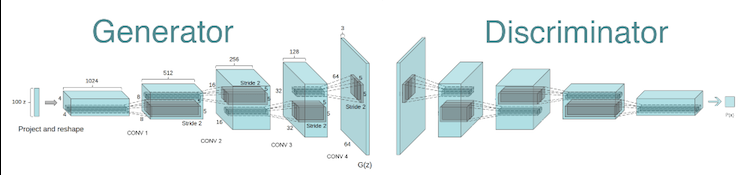

In [0]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/My Drive/basic_gan_architecture.png')
cv2_imshow(image)

Agora é só treinar a rede:

In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated_images(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dimension))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(plot_generated, epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            output_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dimension))
            
            # Generate the output from the noise
            generated_output = g.predict(noise)
            X = np.concatenate((output_batch, generated_output))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated output
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dimension))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Agora configuramos as SEEDs para ter como reproduzir se necessário:

In [0]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value=0

import numpy as np
np.random.seed (seed_value)

A GAN aparentemente não esta convergindo corretamente. O erro da rede discriminadora é muito menor que o erro da rede geradora, então talvez tenhamos que tentar algum outra estratégia.

Alguns links para ajudar:

https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

Aparentemente este problema parece ser comum e chamado de instabilidade da GAN.

Uma das soluções propostas é adicionar ruído nas imagens, tanto originais quanto geradas, para dificultar o aprendizado do descriminador:

> 6. Adding Noise
It is well know that making the training of the discriminator more difficult is beneficial for the overall stability. One of the most known methods to increase the complexity of the discriminator training is adding noise to both the real and synthetic data (for example the images generated by the generator); in the mathematical world this should work because it helps giving some stability to the data distributions of the two competing networks. It really is a simple solution that I recommend trying as it can work quite well in practice (even if it does not magically solve any instability problem that you may encounter), while requiring minimal effort to set up. With that said, I started using this technique but ended up ditching it after some time, preferring some other and in my opinion more effective techniques.

Outra opção é fazer o chamado label smoothing, que reduz o label das imagens reais de 100% para algo como 90%, com o intuito de dificultar sua diferenciação entre imagens falsas e reais.

> 7. Label Smoothing
Another method to achieve the same goal is label smoothing, which is even more easy and straight forward to understand and implement: if the label set for real images is 1, we change it to a lower value, like 0.9. This solution discourages the discriminator from being overconfident about its classification, or in other words from relying on a very limited set of features to determine if an image is real or fake. I completely endorse this little trick as it has shown to work very well in practice and it only requires to change one or two characters in your code.



Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------


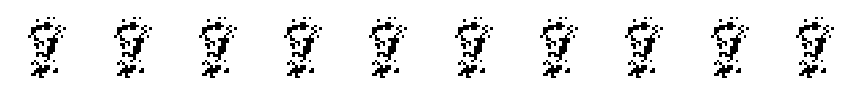

--------------- Epoch 5 ---------------


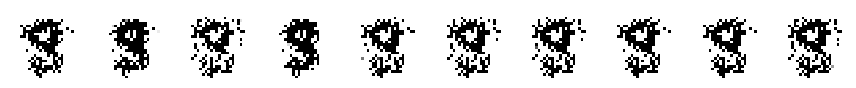

--------------- Epoch 10 ---------------


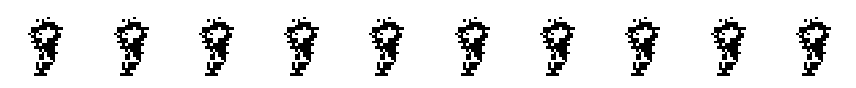

--------------- Epoch 15 ---------------


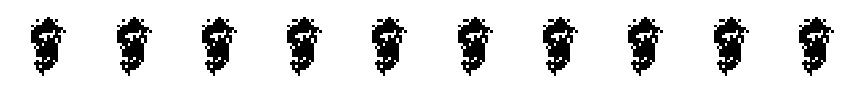

--------------- Epoch 20 ---------------


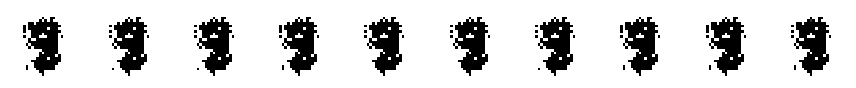

--------------- Epoch 25 ---------------


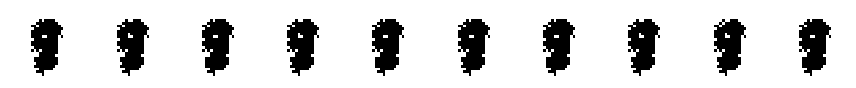

--------------- Epoch 30 ---------------


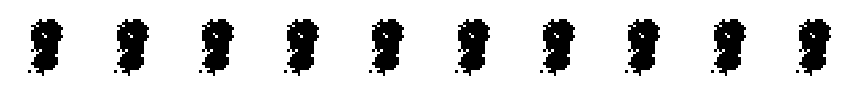

--------------- Epoch 35 ---------------


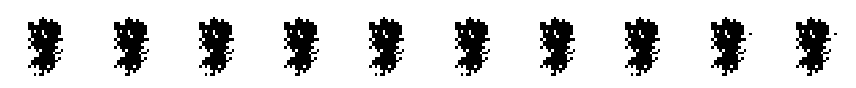

--------------- Epoch 40 ---------------


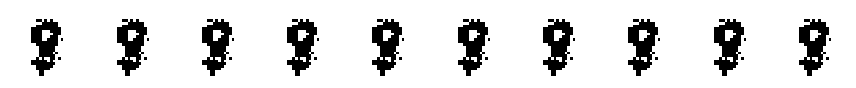

--------------- Epoch 45 ---------------


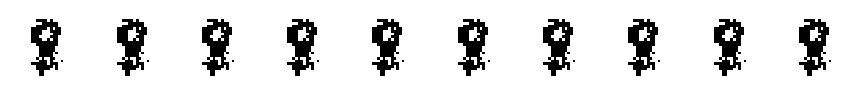

--------------- Epoch 50 ---------------


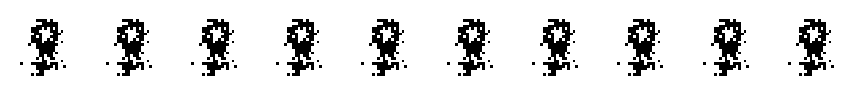

--------------- Epoch 55 ---------------


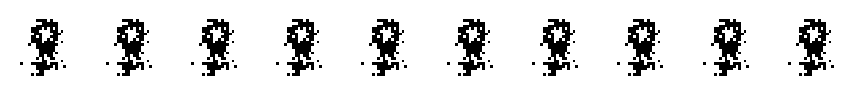

--------------- Epoch 60 ---------------


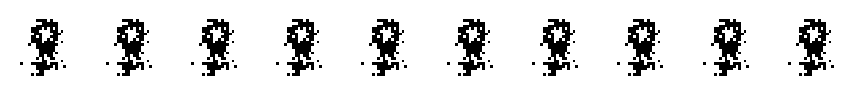

--------------- Epoch 65 ---------------


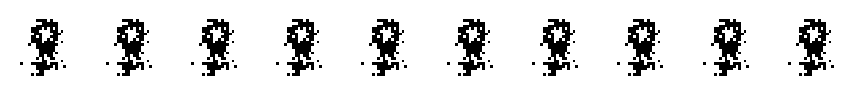

--------------- Epoch 70 ---------------


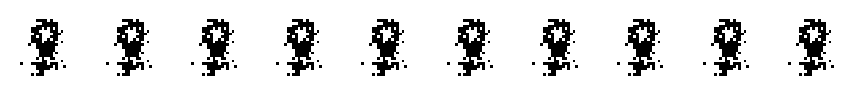

KeyboardInterrupt: ignored

In [0]:
train(plot_generated_images, epochs=200, plt_frq=5, BATCH_SIZE=128)

Agora podemos tentar o MisGAN para gerar os dados de pressao arterial. Abaixo carregamos os dados e mostramos as primeiras 3 linhas.

In [0]:
import pandas as pd

dados_base = pd.read_csv("/content/drive/My Drive/base_pressao.csv") 
dados_pressao = dados_base.to_numpy()[:, 3:].astype(np.float64)

dados_pressao_completos = np.array([exemplo for exemplo in dados_pressao if not np.isnan(exemplo).any()])
dados_pressao_completos = dados_pressao_completos / np.max(dados_pressao_completos)
dados_pressao_incompletos = np.array([exemplo for exemplo in dados_pressao if np.isnan(exemplo).any()]) 

m, n = np.shape(dados_pressao)
print('O total de dados é: ', m)
print('O total de dados completos é: ', len(dados_pressao_completos))
print('O total de dados incompletos é: ', len(dados_pressao_incompletos))
print('O numero de features é: ', n)
menor_exemplo = np.argmin(np.array([np.isnan(exemplo).any().sum() for exemplo in dados_pressao_incompletos]))
maior_exemplo = np.argmax(np.array([np.isnan(exemplo).any().sum() for exemplo in dados_pressao_incompletos]))
print('O menor numero de dados faltando é: ', np.isnan(dados_pressao_incompletos[menor_exemplo]).sum())
print('O maior numero de dados faltando é: ', np.isnan(dados_pressao_incompletos[maior_exemplo]).sum())
print('O maior valor é: ', np.max(dados_pressao_completos))
print('O menor valor é: ', np.min(dados_pressao_completos))

for exemplo in dados_pressao_completos[:5]:
  plt.plot(range(len(exemplo)), exemplo)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

In [0]:
X_train = dados_pressao_completos
adam = Adam(lr=0.0002, beta_1=0.5)
noise_dimension = n

Agora vamos definir uma função de custo comun para gans e que é utilizada na misgan, a wasserstein loss:

In [0]:
import keras.backend as K

def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

Considerando que temos poucos dados completos, será que conseguimos gerar novas amostras do zero para ajudar no treinamento da misgan?

In [0]:
g = Sequential()
g.add(Dense(160, input_dim=noise_dimension, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(640, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(2560, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(160, activation=LeakyReLU(alpha=0.2)))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(2560, input_dim=n, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.1))
g.add(Dense(640, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.1))
g.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.1))
g.add(Dense(160, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.1))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(noise_dimension, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
def generateMixup(alpha):
  newData = np.array([np.zeros(160)])
  # Apply mixup for data augmentation
  for i, example_first in enumerate(X_train):
    for j, example_second in enumerate(X_train):
      if i != j:
        mix = (alpha * (example_first + example_second)).astype(int)
        newData = np.vstack((newData, mix))
  return np.vstack((X_train, newData[1:]))


In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

# X_train = generateMixup(0.5)

print(np.shape(X_train))

def plot_generated_pressures():
  noise = np.random.normal(0, 1, size=(1, noise_dimension))
  generated_pressures = g.predict(noise)
  plt.plot(range(len(generated_pressures[0])), generated_pressures[0])
  plt.axis('off')
  plt.tight_layout()
  plt.show()
  plt.close()
  
train(plot_generated_pressures, epochs=5000, plt_frq=100, BATCH_SIZE=len(X_train))

In [0]:
g.save_weights("/content/drive/My Drive/generator.h5")
d.save_weights("/content/drive/My Drive/descriminator.h5")

Tinha um erro na função de ativação. Agora parece que a rede conseguiu aprender, mais ou menos, como gerar a distribuição dos dados. Podemos comparar o resultado da MisGAN com o acima.

Agora vamos implementar a MisGAN.

In [0]:
image = cv2.imread('/content/drive/My Drive/misgan.png')
cv2_imshow(image)

In [0]:
def mask_data(data, mask, tau=0):
  return mask * data + (1 - mask) * tau

In [0]:
def build_data_generator(gx_noise_dimension, output_dimension):
  gx = Sequential()
  gx.add(Dense(160, input_dim=gx_noise_dimension, activation=LeakyReLU(alpha=0.2)))
  gx.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  gx.add(Dense(640, activation=LeakyReLU(alpha=0.2)))
  gx.add(Dense(output_dimension, activation=LeakyReLU(alpha=0.2)))
  gx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gx

In [0]:
def build_mask_generator(gm_noise_dimension, output_dimension):
  gm = Sequential()
  gm.add(Dense(160, input_dim=gm_noise_dimension, activation=LeakyReLU(alpha=0.2)))
  gm.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  gm.add(Dense(640, activation=LeakyReLU(alpha=0.2)))
  gm.add(Dense(output_dimension, activation='sigmoid'))  # Values between 0 and 1
  gm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gm

In [0]:
def build_data_discriminator(input_dim):
  dx = Sequential()
  dx.add(Dense(640, input_dim=input_dim, activation=LeakyReLU(alpha=0.2)))
  dx.add(Dropout(0.3))
  dx.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  dx.add(Dropout(0.3))
  dx.add(Dense(160, activation=LeakyReLU(alpha=0.2)))
  dx.add(Dropout(0.3))
  dx.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
  dx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return dx

In [0]:
def build_masks_discriminator(input_dim):
  dm = Sequential()
  dm.add(Dense(640, input_dim=input_dim, activation=LeakyReLU(alpha=0.2)))
  dm.add(Dropout(0.3))
  dm.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  dm.add(Dropout(0.3))
  dm.add(Dense(160, activation=LeakyReLU(alpha=0.2)))
  dm.add(Dropout(0.3))
  dm.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
  dm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return dm

In [0]:
def build_gan_data(gx_noise_dimension, output_dimension):
  gx = build_data_generator(gx_noise_dimension, output_dimension)
  dx = build_data_discriminator(output_dimension)
  inputsGx = Input(shape=(gx_noise_dimension, )) 
  hiddenGx = gx(inputsGx)
  outputGx = dx(hiddenGx)
  ganX = Model(inputsGx, outputGx)
  ganX.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gx, dx, ganX

In [0]:
def build_gan_mask(gm_noise_dimension, output_dimension):
  gm = build_mask_generator(gm_noise_dimension, output_dimension)
  dm = build_masks_discriminator(output_dimension)
  inputsGm = Input(shape=(gm_noise_dimension, ))
  hiddenGm = gm(inputsGm)
  outputGm = dm(hiddenGm)
  ganM = Model(inputsGm, outputGm)
  ganM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gm, dm, ganM

In [0]:
def plot_generated_pressures(generator, size, noise_dimension):
  generated_pressures = generator.predict(generate_noise(size, noise_dimension))
  for pressure in generated_prerssures:
    plt.plot(range(len(pressure)), pressure)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
def print_summary(epochs, BATCH_SIZE, batchCount, gx, dx, ganX, gm, dm, ganM):
  print('Epochs:', epochs)
  print('Batch size:', BATCH_SIZE)
  print('Batches per epoch:', batchCount)
  print('-'*10, '-'*5, '-'*10)
  print('-'*10, "Data generator", '-'*10)
  gx.summary()
  print('-'*10, "Data discriminator", '-'*10)
  dx.summary()
  print('-'*10, "Data GAN", '-'*10)
  ganX.summary()
  print('-'*10, "Mask generator", '-'*10)
  gm.summary()
  print('-'*10, "Mask discriminator", '-'*10)
  dm.summary()
  print('-'*10, "Mask GAN", '-'*10)
  ganM.summary()
  print('-'*10, '-'*5, '-'*10)

def generate_noise(size, noise_dimension):
  return np.random.normal(0, 1, size=(size, noise_dimension))

def build_discriminator_batch_input(data, generator, batch_indexes, noise_dimension):
  size = len(batch_indexes)
  generated_input = generator.predict(generate_noise(size, noise_dimension))
  return np.vstack((data[batch_indexes], generated_input))

def build_discriminator_labels(batch_size, label_smothing_coef):
  y = np.zeros(2*batch_size)
  y[:batch_size] = label_smothing_coef  # One-sided label smoothing

def train_generator(gan, discriminator, batch_size, noise_dimension):
  noise = np.random.normal(0, 1, size=(batch_size, noise_dimension))
  y = np.ones(batch_size)
  discriminator.trainable = False
  loss = gan.train_on_batch(noise, y)
  return loss

def train_discriminator(discriminator, inputs, labels):
  discriminator.trainable = True
  return discriminator.train_on_batch(inputs, labels)

def train_misgan(X_train, X_Masks, gx, dx, ganX, gm, dm, ganM, epochs=1000, plt_frq=100, BATCH_SIZE=128):
  # Set up a vector (dict) to store the losses
  losses_data = {"D":[], "G":[]}
  losses_mask = {"D":[], "G":[]}
  m, n = np.shape(X_train)
  gm_noise_dimension = gx_noise_dimension = n
  batchCount = int(m / BATCH_SIZE)
  print_summary(epochs, BATCH_SIZE, batchCount, gx, dx, ganX, gm, dm, ganM)
  
  for e in tqdm_notebook(range(1, epochs+1)):
      if e == 1 or e%plt_frq == 0:
          print('-'*15, 'Epoch %d' % e, '-'*15)
      for _ in range(batchCount):
          # Create a batch by drawing random index numbers from the training set
          batch_indexes = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
          
          # Build discriminators inputs
          dx_inputs = build_discriminator_batch_input(X_train, gx, batch_indexes, gx_noise_dimension)
          dm_inputs = build_discriminator_batch_input(X_Masks, gm, batch_indexes, gm_noise_dimension)
          
          # Build batch labels
          y = build_discriminator_labels(BATCH_SIZE, label_smothing_coef=0.9)

          # Train discriminator on generated output
          dm_loss = train_discriminator(dm, dm_inputs, y)

          # Train discriminator on generated output
          dx_inputs = mask_data(dx_inputs, dm_inputs, 0)
          dx_loss = train_discriminator(dx, dx_inputs, y)
                      
          # Train data generator
          gx_loss = train_generator(ganX, dx, BATCH_SIZE, gx_noise_dimension)

          # Train mask generator
          gm_loss = train_generator(ganM, dm, BATCH_SIZE, gm_noise_dimension)

      # Only store losses from final batch of epoch
      losses_data["D"].append(dx_loss)
      losses_data["G"].append(gx_loss)
      losses_mask["D"].append(dm_loss)
      losses_mask["G"].append(gm_loss)
      
      # Update the plots
      if e == 1 or e%plt_frq == 0:
          plot_generated_pressures(5, gx_noise_dimension)
  plot_loss(losses_data)
  plot_loss(losses_mask)

In [0]:
X_train = dados_pressao

X_Masks = np.array(np.invert([np.isnan(exemplo) for exemplo in X_train])).astype(int)

X_train = np.nan_to_num(X_train)

output_dimension = n
gx_noise_dimension = n
gm_noise_dimension = n

gx, dx, ganX = build_gan_data(gm_noise_dimension, output_dimension)
gm, dm, ganM = build_gan_mask(gm_noise_dimension, output_dimension)

train_misgan(X_train, X_Masks, gx, dx, ganX, gm, dm, ganM, epochs=1000, plt_frq=100, BATCH_SIZE=len(X_train))

In [0]:
image = cv2.imread('/content/drive/My Drive/MisGan_inputation.png')
cv2_imshow(image)

In [0]:
image = cv2.imread('/content/drive/My Drive/imputer_equation.png')
cv2_imshow(image)

In [0]:
def build_imputation_generator(input_dimension, output_dimension):
  gi = Sequential()
  gi.add(Dense(160, input_dim=input_dimension, activation=LeakyReLU(alpha=0.2)))
  gi.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  gi.add(Dense(640, activation=LeakyReLU(alpha=0.2)))
  gi.add(Dense(output_dimension, activation=LeakyReLU(alpha=0.2)))
  gi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gi

In [0]:
def build_imputation_discriminator(input_dimension):
  di = Sequential()
  di.add(Dense(640, input_dim=input_dimension, activation=LeakyReLU(alpha=0.2)))
  di.add(Dropout(0.3))
  di.add(Dense(320, activation=LeakyReLU(alpha=0.2)))
  di.add(Dropout(0.3))
  di.add(Dense(160, activation=LeakyReLU(alpha=0.2)))
  di.add(Dropout(0.3))
  di.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
  di.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return dx

In [0]:
def build_gan_imputation(noise_dimension, output_dimension):
  gi = build_imputation_generator(noise_dimension, output_dimension))
  di = build_imputation_discriminator(noise_dimension, output_dimension)
  inputsGi = Input(shape=(noise_dimension, ))
  hiddenGi = gi(inputsGi)
  outputGi = di(hiddenGi)
  ganI = Model(inputsGi, outputGi)
  ganI.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return gi, di, ganI

In [0]:
def print_summary(epochs, BATCH_SIZE, batchCount, gi, di, ganI):
  print('Epochs:', epochs)
  print('Batch size:', BATCH_SIZE)
  print('Batches per epoch:', batchCount)
  print('-'*10, '-'*5, '-'*10)
  print('-'*10, "Imputation generator", '-'*10)
  gi.summary()
  print('-'*10, "Imputation discriminator", '-'*10)
  di.summary()
  print('-'*10, "Imputation GAN", '-'*10)
  ganI.summary()
  print('-'*10, '-'*5, '-'*10)

def generate_noise(size, noise_dimension):
  return np.random.normal(0, 1, size=(size, noise_dimension))

def build_generator_input(data, masks, complement_mask, size, noise_dimension):
  return data * masks + generate_noise(size, noise_dimension) * complement_mask

def build_discriminator_batch_input(data, masks, gi, gx):
  size, noise_dimension = np.shape(data)
  complement_mask = (1 - masks)
  generator_input = build_generator_input(data, masks, complement_mask, size, noise_dimension)
  gi_generated = data * masks + generator.predict(generator_input) * complement_mask
  gx_generated = gx.predict(generate_noise(size, noise_dimension))
  return np.vstack((gx_generated, gi_generated))

def build_discriminator_labels(batch_size, label_smothing_coef):
  y = np.zeros(2*batch_size)
  y[:batch_size] = label_smothing_coef  # One-sided label smoothing

def train_generator(gan, discriminator, data, masks):
  size, noise_dimension = np.shape(data)
  complement_mask = invert(masks)
  generator_input = build_generator_input(data, masks, complement_mask, size, noise_dimension)
  discriminator.trainable = False
  return gan.train_on_batch(generator_input, np.ones(size))

def train_discriminator(discriminator, inputs, labels):
  discriminator.trainable = True
  return discriminator.train_on_batch(inputs, labels)

def train_misgan_imputation(X_train, X_Masks, gx, gi, di, ganI, epochs=1000, plt_frq=100, BATCH_SIZE=128):
  # Set up a vector (dict) to store the losses
  losses = {"D":[], "G":[]}

  m, n = np.shape(X_train)
  gx_noise_dimension = gm_noise_dimension = n
  batchCount = int(m / BATCH_SIZE)
  print_summary(epochs, BATCH_SIZE, batchCount, gi, di, ganI)
  
  for e in tqdm_notebook(range(1, epochs+1)):
    if e == 1 or e%plt_frq == 0:
      print('-'*15, 'Epoch %d' % e, '-'*15)
    for _ in range(batchCount):
      # Create a batch by drawing random index numbers from the training set
      batch_indexes = np.random.randint(0, m, size=BATCH_SIZE)
      
      # Build discriminators inputs
      di_inputs = build_discriminator_batch_input(X_train[batch_indexes], X_Masks[batch_indexes], gi, gx)
      
      # Build batch labels
      y = build_discriminator_labels(BATCH_SIZE, label_smothing_coef=1)

      # Train discriminator on generated output
      di_loss = train_discriminator(di, di_inputs, y)
      
      # Train data generator
      gi_loss = train_generator(ganI, di, X_train[batch_indexes], X_Masks[batch_indexes])

    # Only store losses from final batch of epoch
    losses_data["D"].append(di_loss)
    losses_data["G"].append(gi_loss)
    
    # Update the plots
    if e == 1 or e%plt_frq == 0:
      plot_generated_pressures(5, gx_noise_dimension)
  plot_loss(losses)